# License detector pipeline visualization

In [34]:
import cv2
import matplotlib

from matplotlib import pyplot as plt

import numpy as np


def show(image: np.ndarray):
    if len(image.shape) == 2:
        plt.imshow(image, aspect="auto", cmap="gray")
    else:
        plt.imshow(image[...,::-1], aspect="auto", cmap="hsv")
    plt.axis("off")
    plt.show()


path = "../datasets/01-polish-licence-plates/train/0001Z4JTCII2TV0E-C122-F4_jpg.rf.a098ae845ee8bda6ed47e08e34b9ccf2.jpg"

matplotlib.rcParams["savefig.pad_inches"] = 0

## Image loading

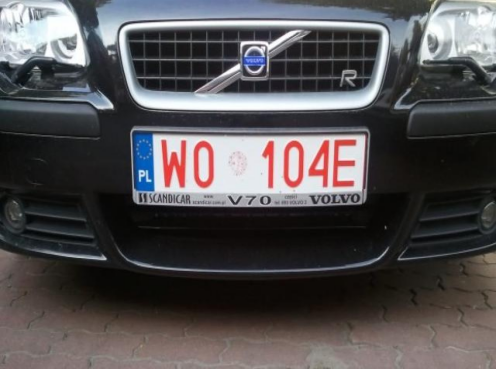

In [35]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

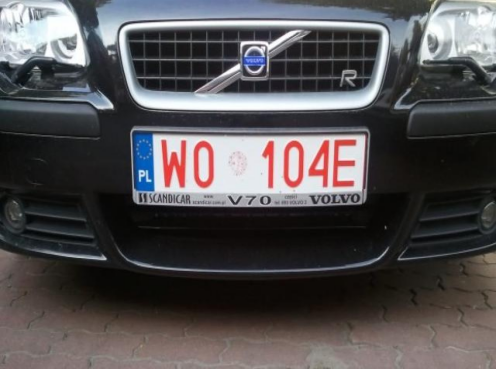

In [36]:
from twm_proj.implementation.initial_filter import InitialFilter

filtered = InitialFilter().filter(image)
show(filtered)

## Edge filter

array([  0, 255], dtype=uint8)

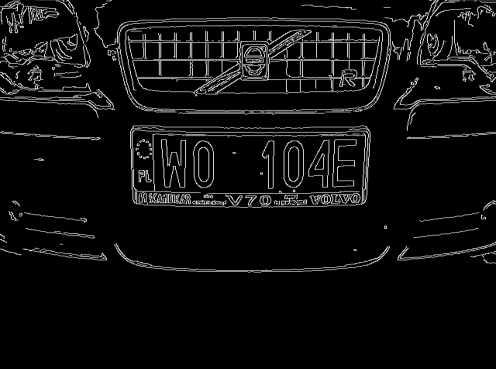

In [38]:
from twm_proj.implementation.edge_filter import EdgeFilter

filtered = EdgeFilter().filter(image)
display(np.unique(filtered))
show(filtered)